# Binning code

## Make sure the code that creates the binned_dic you care about is here. Just copy and paste it into a new cell after this one if it isn't

In [42]:
import pandas as pd
df = pd.read_csv('wfC318/Day_0/Raw_files_csv/combined_behavior_and_s.csv', header=None)

#adding labels to the data
labs = ['frame', 'time', 'odor_valve', 'total_licks', 'total_rewards', 'trial', 
        'valve_open', 'virt_dist', 'total_distance', 'lap', 'trial_type', 'speed']

#name the rest of the columns with neuron index
for i in range(0,255):
    labs.append(str(i))
    
df.columns = labs
print(df.head())

   frame  time  odor_valve  total_licks  total_rewards  trial  valve_open  \
0      1    34           0            0              0      0           0   
1      2    84           0            0              0      0           0   
2      3   133           0            0              0      0           0   
3      4   183           0            0              0      0           0   
4      5   233           0            0              0      0           0   

   virt_dist  total_distance  lap ...   245     246  247  248  249  250  251  \
0         13               0    0 ...   0.0  0.0000  0.0  0.0  0.0  0.0  0.0   
1         26               0    0 ...   0.0  2.7654  0.0  0.0  0.0  0.0  0.0   
2         36               0    0 ...   0.0  0.0000  0.0  0.0  0.0  0.0  0.0   
3         50               0    0 ...   0.0  0.0000  0.0  0.0  0.0  0.0  0.0   
4         65               0    0 ...   0.0  0.0000  0.0  0.0  0.0  0.0  0.0   

   252  253  254  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  

In [43]:
#remove all trials after 30
df = df[df["trial"] < 31]

#restart time so it increments within a given trial only
#do not run this cell more than once or it will fuck everything up
trial_prev, time_prev, end_time = 0,0,0
for i, j in df.iterrows(): 
    trial = int(j['trial'])
    time = int(j['time'])
    if trial != trial_prev:
        end_time = time_prev
        #print("\n")
    df.at[i,'time'] = time - end_time
    trial_prev = trial
    time_prev = time

In [44]:
#remove all cells where distance exceeds 4,000cm
df = df[df["virt_dist"] < 4000]

In [1]:
import pandas as pd
import numpy as np
import time as t

#filename = 'wfC318/Day_4/raw_files_csv/combined_behavior_and_s.csv'
filename = 'wfC318/Day_0/Raw_files_csv/combined_behavior_and_s.csv'

# How many trials we are looking at (ex: 31 for day 0, 34 for day 4)
trial_count = 31

data = pd.read_csv(filename, header=None)

def changeTime(data_name):
    trial_prev, time_prev, end_time = 0,0,0
    for i, j in data_name.iterrows():
        trial = int(j[9])
        time = int(j[1])
        if trial != trial_prev:
            end_time = time_prev
        data_name.at[i,1] = time - end_time
        trial_prev = trial
        time_prev = time
    print("time changed")
    
changeTime(data)

length = len(data)
#data = data[data[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm

time = data[1]
odor = data[10]
distance = data[7]
lap = data[9]
# neuron data starts at column "13", indexed from 0 so the first column of neuron data is data[12]
cell = data.loc[:, 12:(len(data.columns)-1)]  # neuron data

#trial_count = max(lap)  # all of them

lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    lap_dictionary[i] = data.loc[data[9] == i]  # associate all lap data with that lap

def findShortestTrial():
    min_time = 999999999
    max_time = 0
    shortest_trial = lap_dictionary[0]
    longest_trial = lap_dictionary[0]
    time_list = []
    for trial in lap_dictionary:
        # first row where mouse passes 4000cm, indicated by lapCount increment
        first = lap_dictionary[trial].loc[ lap_dictionary[trial][5] > trial ]
        #print(first)
        last = lap_dictionary[trial].iloc[-1]
        time = last[1] - first.iloc[0,1]
        #print(last[1], first.iloc[0,1], time)
        time_list.append(time)
        if(time < min_time):
            min_time = time
            shortest_trial = trial
        if (time > max_time):
            max_time = time
            longest_trial = trial
    return shortest_trial, min_time, longest_trial, max_time

shortest_trial, min_time,longest_trial, max_time = findShortestTrial()
print("Shortest Trial:", shortest_trial, "Time: ", min_time)
print("Longest Trial:", longest_trial, "Time: ", max_time)


# Determining number of bins
num_of_time_bins = int(min_time // 200)
num_of_space_bins = 4000//100 # 100cm bin width 
print("number of time bins:", num_of_time_bins)

NEW_lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    NEW_lap_dictionary[i] = data.loc[(data[9] == i) & (data[7] > 4000)]  # associate all lap data with that lap
    #print(NEW_lap_dictionary[i])

def timeBinning():
    # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in NEW_lap_dictionary:  # for every trial
        #print("TEST", NEW_lap_dictionary[i], "\n\n")
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        first = NEW_lap_dictionary[i].loc[ NEW_lap_dictionary[i][5] > i ]
        #print("HEREEE", first)
        inceptionTIME = first.iloc[0,1]
        
        #inceptionTIME = 
        for bin_number in range(1, num_of_time_bins+1):
            bin_ending_time = bin_number*200
            last_time = (bin_number-1)*200
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = NEW_lap_dictionary[i].loc[(NEW_lap_dictionary[i][1] < bin_ending_time + inceptionTIME) & (NEW_lap_dictionary[i][1] >= last_time+inceptionTIME) ]
            list_of_bins[bin_ending_time] = data_points
            #print(data_points)
        dict_of_all_bins[i] = list_of_bins

    return dict_of_all_bins
time_binned_dict_day0_reward = timeBinning()
print("temporally binned dictionary")

time changed
Shortest Trial: 20 Time:  4250.0
Longest Trial: 9 Time:  4652.0
number of time bins: 21
temporally binned dictionary


# Reward day 0

In [45]:
import pandas as pd
import numpy as np
import time as t

#filename = 'wfC318/Day_4/raw_files_csv/combined_behavior_and_s.csv'
filename = 'wfC318/Day_0/Raw_files_csv/combined_behavior_and_s.csv'

# How many trials we are looking at (ex: 31 for day 0, 34 for day 4)
trial_count = 31

data = pd.read_csv(filename, header=None)

def changeTime(data_name):
    trial_prev, time_prev, end_time = 0,0,0
    for i, j in data_name.iterrows():
        trial = int(j[9])
        time = int(j[1])
        if trial != trial_prev:
            end_time = time_prev
        data_name.at[i,1] = time - end_time
        trial_prev = trial
        time_prev = time
    print("time changed")
    
changeTime(data)

length = len(data)
#data = data[data[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm

time = data[1]
odor = data[10]
distance = data[7]
lap = data[9]
# neuron data starts at column "13", indexed from 0 so the first column of neuron data is data[12]
cell = data.loc[:, 12:(len(data.columns)-1)]  # neuron data

#trial_count = max(lap)  # all of them

lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    lap_dictionary[i] = data.loc[data[9] == i]  # associate all lap data with that lap

def findShortestTrial():
    min_time = 999999999
    max_time = 0
    shortest_trial = lap_dictionary[0]
    longest_trial = lap_dictionary[0]
    time_list = []
    for trial in lap_dictionary:
        # first row where mouse passes 4000cm, indicated by lapCount increment
        first = lap_dictionary[trial].loc[ lap_dictionary[trial][5] > trial ]
        #print(first)
        last = lap_dictionary[trial].iloc[-1]
        time = last[1] - first.iloc[0,1]
        #print(last[1], first.iloc[0,1], time)
        time_list.append(time)
        if(time < min_time):
            min_time = time
            shortest_trial = trial
        if (time > max_time):
            max_time = time
            longest_trial = trial
    return shortest_trial, min_time, longest_trial, max_time

shortest_trial, min_time,longest_trial, max_time = findShortestTrial()
print("Shortest Trial:", shortest_trial, "Time: ", min_time)
print("Longest Trial:", longest_trial, "Time: ", max_time)


# Determining number of bins
num_of_time_bins = int(min_time // 200)
num_of_space_bins = 4000//100 # 100cm bin width 
print("number of time bins:", num_of_time_bins)

NEW_lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    NEW_lap_dictionary[i] = data.loc[(data[9] == i) & (data[7] > 4000)]  # associate all lap data with that lap
    #print(NEW_lap_dictionary[i])

def timeBinning():
    # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in NEW_lap_dictionary:  # for every trial
        #print("TEST", NEW_lap_dictionary[i], "\n\n")
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        first = NEW_lap_dictionary[i].loc[ NEW_lap_dictionary[i][5] > i ]
        #print("HEREEE", first)
        inceptionTIME = first.iloc[0,1]
        
        #inceptionTIME = 
        for bin_number in range(1, num_of_time_bins+1):
            bin_ending_time = bin_number*200
            last_time = (bin_number-1)*200
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = NEW_lap_dictionary[i].loc[(NEW_lap_dictionary[i][1] < bin_ending_time + inceptionTIME) & (NEW_lap_dictionary[i][1] >= last_time+inceptionTIME) ]
            list_of_bins[bin_ending_time] = data_points
            #print(data_points)
        dict_of_all_bins[i] = list_of_bins

    return dict_of_all_bins
time_binned_dict_day0_reward = timeBinning()
print("temporally binned dictionary")

#print(binned_dic)



time changed
Shortest Trial: 20 Time:  4250.0
Longest Trial: 9 Time:  4652.0
number of time bins: 21
temporally binned dictionary


## Time cells in Day 0 no odor

In [18]:
import pandas as pd
import numpy as np
import time as t

# Things to set:
#filename = 'wfC318/Day_4/raw_files_csv/combined_behavior_and_s_COPY.csv'
#filename = 'wfC318/Day_4/raw_files_csv/combined_behavior_and_s.csv'
filename = 'wfC318/Day_0/Raw_files_csv/combined_behavior_and_s.csv'

# How many trials we are looking at (ex: 31 for day 0, 34 for day 4)
trial_count = 31


data = pd.read_csv(filename, header=None)

# Will change neuron firing data to (0,1) binary indicators
data_for_freq = pd.read_csv(filename, header=None)

def changeTime(data_name):
    trial_prev, time_prev, end_time = 0,0,0
    for i, j in data_name.iterrows():
        trial = int(j[9])
        time = int(j[1])
        if trial != trial_prev:
            end_time = time_prev
        data_name.at[i,1] = time - end_time
        trial_prev = trial
        time_prev = time
    print("time changed")
    
changeTime(data)
changeTime(data_for_freq)


length = len(data)
data = data[data[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm
data_for_freq = data_for_freq[data_for_freq[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm


time = data[1]
odor = data[10]
distance = data[7]
lap = data[9]
# neuron data starts at column "13", indexed from 0 so the first column of neuron data is data[12]
cell = data.loc[:, 12:(len(data.columns)-1)]  # neuron data

#trial_count = max(lap)  # all of them


# using lambda function instead
def binaryIndicator(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x


# Using second copy of data to change neuron data to (0,1) to calculate 10% threshold
# Changing neuron firing data to 0,1 binary
num_of_cols = len(data_for_freq.columns)
for j in range(12, num_of_cols):  # for all neuron columns
    # setting value to 1 if val>0, 0 otherwise
    data_for_freq[j] = data_for_freq[j].apply(lambda x: 1 if (x > 0) else 0)
    #data_for_freq[j] = data_for_freq[j].apply(binaryIndicator)


lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    lap_dictionary[i] = data.loc[data[9] == i]  # associate all lap data with that lap


def findShortestTrial():
    min_time = 999999999
    max_time = 0
    shortest_trial = lap_dictionary[0]
    longest_trial = lap_dictionary[0]
    time_list = []
    for trial in lap_dictionary:
        first = lap_dictionary[trial].iloc[0]
        last = lap_dictionary[trial].iloc[-1]
        time = last[1] - first[1]
        time_list.append(time)
        if(time < min_time):
            min_time=time
            shortest_trial = trial
        if (time > max_time):
            max_time = time
            longest_trial = trial
    return shortest_trial, min_time, longest_trial, max_time

shortest_trial, min_time,longest_trial, max_time = findShortestTrial()
print("Shortest Trial:", shortest_trial, "Time: ", min_time)
print("Longest Trial:", longest_trial, "Time: ", max_time)


# Determining number of bins
num_of_time_bins = int(min_time // 200)
num_of_space_bins = 4000//100 # 100cm bin width 
print("number of time bins:", num_of_time_bins)


# create empty row to store neuron data frequencies
empty_row = {}
for k in range(0, num_of_cols-13):  # 255 or 459 columns for example
    empty_row[k] = 0.0

def findMeanValues():
    flagCounter = 0
    test_dictionary_for_laps = {}
    start = t.time()  # for reference
    for i in lap_dictionary:  # for every trial
        # average columns in that trial to test (eventually, in bin instead)
        current_row = pd.DataFrame(empty_row, index=[0])  # create pandas dataframe from a row of 0's (reset every lap)
        for j in range(12, num_of_cols):  # for all neuron columns
            #current_row[j - 12] = data[j].mean()
            current_row[j-12] = lap_dictionary[i][j].mean()  # fill each column spot in that row with the mean of all values in that column
            # note: because we set values to (0,1), this mean becomes frequency relative to that trial
        test_dictionary_for_laps[i] = current_row  # set dictionary item equal to that row
    end = t.time()
    return test_dictionary_for_laps

test_dictionary_for_laps = findMeanValues()

NEW_lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    NEW_lap_dictionary[i] = data.loc[data[9] == i]  # associate all lap data with that lap
    #print(NEW_lap_dictionary[i].iloc[:,:13], "\n\n")
    
def timeBinning():
    # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in NEW_lap_dictionary:  # for every trial
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        for bin_number in range(1, num_of_time_bins+1):
            bin_ending_time = bin_number*200
            last_time = (bin_number-1)*200
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = NEW_lap_dictionary[i].loc[(NEW_lap_dictionary[i][1] < bin_ending_time) & (NEW_lap_dictionary[i][1] >= last_time) ]
            list_of_bins[bin_ending_time] = data_points
        dict_of_all_bins[i] = list_of_bins

    return dict_of_all_bins
time_binned_dict_day0 = timeBinning()
print("temporally binned dictionary")

def spaceBinning():
     # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in NEW_lap_dictionary:  # for every trial
        #print("TEST", NEW_lap_dictionary[i], "\n\n")
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        for bin_number in range(1, num_of_space_bins+1):
            bin_starting_dist = bin_number*100  # 10 cm bin width
            last_dist = (bin_number-1)*100
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = NEW_lap_dictionary[i].loc[(NEW_lap_dictionary[i][7] < bin_starting_dist) & (NEW_lap_dictionary[i][7] >= last_dist) ]
            list_of_bins[bin_starting_dist] = data_points
            #print(data_points)
        dict_of_all_bins[i] = list_of_bins

    return dict_of_all_bins
space_binned_dict_day0 = spaceBinning()
print("spatially binned dictionary")



time changed
time changed
Shortest Trial: 29 Time:  8702.0
Longest Trial: 20 Time:  16705.0
number of time bins: 43
temporally binned dictionary
spatially binned dictionary


# Day 4 both odors

In [53]:
import pandas as pd
import numpy as np
import time as t

filename = 'wfC318/Day_4/raw_files_csv/combined_behavior_and_s.csv'
#filename = 'wfC318/Day_0/Raw_files_csv/combined_behavior_and_s.csv'

# How many trials we are looking at (ex: 31 for day 0, 34 for day 4)
trial_count = 31

data_day4_tot = pd.read_csv(filename, header=None)
data_day4_odor1 = pd.read_csv(filename, header=None)
data_day4_odor2 = pd.read_csv(filename, header=None)

def changeTime(data_name):
    trial_prev, time_prev, end_time = 0,0,0
    for i, j in data_name.iterrows():
        trial = int(j[9])
        time = int(j[1])
        if trial != trial_prev:
            end_time = time_prev
        data_name.at[i,1] = time - end_time
        trial_prev = trial
        time_prev = time
    print("time changed")

changeTime(data_day4_tot)
changeTime(data_day4_odor1)
changeTime(data_day4_odor2)


data_day4_tot = data_day4_tot[data_day4_tot[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm

data_day4_odor1 = data_day4_odor1[data_day4_odor1[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm
data_day4_odor1 = data_day4_odor1[data_day4_odor1[10] == 1]

data_day4_odor2 = data_day4_odor2[data_day4_odor2[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm
data_day4_odor2 = data_day4_odor2[data_day4_odor2[10] == 2]


unique_trial_ids1 = data_day4_odor1[9].unique()
unique_trial_ids2 = data_day4_odor2[9].unique()


#trial_count = max(lap)  # all of them

"""
Dictionary of all trials
"""
lap_dict_tot = {}
for i in range(0, trial_count):  # for every lap
    lap_dict_tot[i] = data_day4_tot.loc[data_day4_tot[9] == i]  # associate all lap data with that lap



"""
Dictionary of just day 4 odor 1
"""
trial_indices1 = []
lap_dict_day4odor1 = {}
counter=0
for i in range(0, len(unique_trial_ids1)):  # for every lap
    idx = int(unique_trial_ids1[counter])
    trial_indices1.append(idx)
    # associate all lap data with that lap, when there is no odor, 
    # so we can no longer directly associate the dictionary index with the trial number
    lap_dict_day4odor1[idx] = data_day4_odor1.loc[data_day4_odor1[9] == idx]
    counter+=1

    

"""
Dictionary of just day 4 odor 2
"""   
trial_indices2 = []
lap_dict_day4odor2 = {}
counter=0
for i in range(0, len(unique_trial_ids2)):  # for every lap
    idx = int(unique_trial_ids2[counter])
    trial_indices2.append(idx)
    # associate all lap data with that lap, when there is no odor, 
    # so we can no longer directly associate the dictionary index with the trial number
    lap_dict_day4odor2[idx] = data_day4_odor2.loc[data_day4_odor2[9] == idx]
    counter+=1



def findShortestTrial(lap_dictionary):
    min_time = 999999999
    max_time = 0
    shortest_trial = lap_dictionary[0]
    longest_trial = lap_dictionary[0]
    time_list = []
    for trial in lap_dictionary:
        first = lap_dictionary[trial].iloc[0]
        last = lap_dictionary[trial].iloc[-1]
        time = last[1] - first[1]
        time_list.append(time)
        if(time < min_time):
            min_time=time
            shortest_trial = trial
        if (time > max_time):
            max_time = time
            longest_trial = trial
    #print("AVG trial duration:", sum(time_list)/len(time_list))
    return shortest_trial, min_time, longest_trial, max_time

shortest_trial, min_time,longest_trial, max_time = findShortestTrial(lap_dict_tot)
print("Shortest Trial:", shortest_trial, "Time: ", min_time)
print("Longest Trial:", longest_trial, "Time: ", max_time)

# Determining number of bins
num_of_time_bins = int(min_time // 200)
num_of_space_bins = 4000//100 # 100cm bin width 
print("number of time bins:", num_of_time_bins)


def timeBinning(lap_dictionary):
    # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in lap_dictionary:  # for every trial
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        for bin_number in range(1, num_of_time_bins+1):
            bin_ending_time = bin_number*200
            last_time = (bin_number-1)*200
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = lap_dictionary[i].loc[(lap_dictionary[i][1] < bin_ending_time) & (lap_dictionary[i][1] >= last_time) ]
            list_of_bins[bin_ending_time] = data_points
        dict_of_all_bins[i] = list_of_bins
    return dict_of_all_bins


def spaceBinning(lap_dictionary):
     # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in lap_dictionary:  # for every trial
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        for bin_number in range(1, num_of_space_bins+1):
            bin_starting_dist = bin_number*100  # 10 cm bin width
            last_dist = (bin_number-1)*100
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = lap_dictionary[i].loc[(lap_dictionary[i][7] < bin_starting_dist) & (lap_dictionary[i][7] >= last_dist) ]
            list_of_bins[bin_starting_dist] = data_points
        dict_of_all_bins[i] = list_of_bins
    return dict_of_all_bins



time_binned_dict_day4odor1 = timeBinning(lap_dict_day4odor1)
time_binned_dict_day4odor2 = timeBinning(lap_dict_day4odor2)
print("temporally binned dictionary")

space_binned_dict_day4odor1 = spaceBinning(lap_dict_day4odor1)
space_binned_dict_day4odor2 = spaceBinning(lap_dict_day4odor2)
print("spatially binned dictionary")




time changed
time changed
time changed
Shortest Trial: 4 Time:  6901.0
Longest Trial: 30 Time:  12502.0
number of time bins: 34
temporally binned dictionary
spatially binned dictionary


# Time cells in day 5 no odor trials

In [27]:
import pandas as pd
import numpy as np
import time as t

filename = 'wfC318/Day_5/combined_behavior_and_s_day5.csv'
# How many trials we are looking at (ex: 31 for day 0, 34 for day 4)
trial_count = 31

data = pd.read_csv(filename, header=None)
#data_for_freq = pd.read_csv(filename, header=None)

def changeTime(data_name):
    trial_prev, time_prev, end_time = 0,0,0
    for i, j in data_name.iterrows():
        trial = int(j[9])
        time = int(j[1])
        if trial != trial_prev:
            end_time = time_prev
        data_name.at[i,1] = time - end_time
        trial_prev = trial
        time_prev = time
    print("time changed")
    
changeTime(data)

length = len(data)
data = data[data[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm
data = data[data[10] <= 1]  # removes all trials where trial type=2(there's odor)

unique_trial_ids = data[9].unique()
#print(type(unique_trial_ids), type(unique_trial_ids[0]))

time = data[1]
odor = data[10]
distance = data[7]
lap = data[9]
# neuron data starts at column "13", indexed from 0 so the first column of neuron data is data[12]
cell = data.loc[:, 12:(len(data.columns)-1)]  # neuron data

#trial_count = max(lap)  # all of them


# using lambda function instead
def binaryIndicator(x):
    if x > 0:
        x = 1
    else:
        x = 0
    return x

"""
# Using second copy of data to change neuron data to (0,1) to calculate 10% threshold
# Changing neuron firing data to 0,1 binary
num_of_cols = len(data_for_freq.columns)
for j in range(12, num_of_cols):  # for all neuron columns
    # setting value to 1 if val>0, 0 otherwise
    data_for_freq[j] = data_for_freq[j].apply(lambda x: 1 if (x > 0) else 0)
    #data_for_freq[j] = data_for_freq[j].apply(binaryIndicator)
"""

trial_indices = []
lap_dictionary = {}
counter=0
for i in range(0, len(unique_trial_ids)):  # for every lap
    idx = int(unique_trial_ids[counter])
    trial_indices.append(idx)
    # associate all lap data with that lap, when there is no odor, 
    # so we can no longer directly associate the dictionary index with the trial number
    lap_dictionary[idx] = data.loc[data[9] == idx]
    counter+=1

print("\n",trial_indices,"\n")

def findShortestTrial():
    min_time = 999999999
    max_time = 0
    shortest_trial = lap_dictionary[1]
    longest_trial = lap_dictionary[1]
    time_list = []
    for trial in lap_dictionary:
        #pair = lap_dictionary[trial].iloc[[0, -1]]
        first = lap_dictionary[trial].iloc[0]
        last = lap_dictionary[trial].iloc[-1]
        time = last[1] - first[1]
        time_list.append(time)
        if(time < min_time):
            min_time=time
            shortest_trial = trial
        if (time > max_time):
            max_time = time
            longest_trial = trial

    #print("AVG trial duration:", sum(time_list)/len(time_list))
    return shortest_trial, min_time, longest_trial, max_time

shortest_trial, min_time,longest_trial, max_time = findShortestTrial()
print("Shortest Trial:", shortest_trial, "Time: ", min_time)
print("Longest Trial:", longest_trial, "Time: ", max_time)


# Determining number of bins
num_of_time_bins = int(min_time // 200)
num_of_space_bins = 4000//100 # 100cm bin width 
print("number of time bins:", num_of_time_bins)


# create empty row to store neuron data frequencies
empty_row = {}
for k in range(0, num_of_cols-13):  # 255 or 459 columns for example
    empty_row[k] = 0.0
def findMeanValues():
    flagCounter = 0
    test_dictionary_for_laps = {}
    for i in lap_dictionary:  # for every trial
        # average columns in that trial to test (eventually, in bin instead)
        current_row = pd.DataFrame(empty_row, index=[0])  # create pandas dataframe from a row of 0's (reset every lap)
        for j in range(12, num_of_cols):  # for all neuron columns
            current_row[j-12] = lap_dictionary[i][j].mean()  # fill each column spot in that row with the mean of all values in that column
            # note: because we set values to (0,1), this mean becomes frequency relative to that trial
        test_dictionary_for_laps[i] = current_row  # set dictionary item equal to that row
    return test_dictionary_for_laps

#test_dictionary_for_laps = findMeanValues()

def timeBinning():
    # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in lap_dictionary:  # for every trial
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        for bin_number in range(1, num_of_time_bins+1):
            bin_ending_time = bin_number*200
            last_time = (bin_number-1)*200
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = lap_dictionary[i].loc[(lap_dictionary[i][1] < bin_ending_time) & (lap_dictionary[i][1] >= last_time) ]
            list_of_bins[bin_ending_time] = data_points
        dict_of_all_bins[i] = list_of_bins

    return dict_of_all_bins
time_binned_dict_day5 = timeBinning()
print("temporally binned dictionary")

def spaceBinning():
     # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in lap_dictionary:  # for every trial
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        for bin_number in range(1, num_of_space_bins+1):
            bin_starting_dist = bin_number*100  # 10 cm bin width
            last_dist = (bin_number-1)*100
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = lap_dictionary[i].loc[(lap_dictionary[i][7] < bin_starting_dist) & (lap_dictionary[i][7] >= last_dist) ]
            list_of_bins[bin_starting_dist] = data_points
        dict_of_all_bins[i] = list_of_bins

    return dict_of_all_bins
space_binned_dict_day5 = spaceBinning()
print("spatially binned dictionary")

time changed

 [1, 3, 4, 6, 9, 11, 13, 16, 18, 19, 22, 23, 25, 26, 29, 30, 32, 35, 38, 39, 41, 43, 45, 47, 49, 50, 53, 56, 58, 59, 61, 63, 66, 68, 69, 70, 73, 74, 77, 79, 81, 82, 85, 88, 89, 91, 93, 94, 96, 99] 

Shortest Trial: 25 Time:  5701.0
Longest Trial: 32 Time:  19853.0
number of time bins: 28
temporally binned dictionary
spatially binned dictionary


# Reshaping data for shuffle test

## NOTE: reset the value of "binned_dic" to match the dictionary you are analyzing


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import os 

#Set binned_dic = whatever dictionary you care about
#this should work as long as the data is binned according to TIME
binned_dic = time_binned_dict_day0

times,cells,spikes,t = [],[],[],[]
data_dic = {}
for trial,bin in binned_dic.items():
    for time,activities in bin.items():
        #print("time:", time)
        for cell,v in activities.items():
            if cell <= 12:  # to skip over behavior and metadata
                continue
            activity_sum = 0
            count = 0
            for x in v:
                activity_sum += x
                count += 1
            mean_activity = activity_sum / count
            t.append(trial)
            times.append(time)
            cells.append(cell)
            spikes.append(mean_activity)
    #data_dic["trial"] = trials
    data_dic["trial"] = t
    data_dic["times"] = times
    data_dic["cells"] = cells
    data_dic["spikes"] = spikes

df = pd.DataFrame.from_dict(data_dic)

print(df.head())

   trial  times  cells  spikes
0      0    200     13     0.0
1      0    200     14     0.0
2      0    200     15     0.0
3      0    200     16     0.0
4      0    200     17     0.0


# Performs 100 shuffles and stores the distributions in the dictionary "shuffled_spike"

In [64]:
def shuffle_cells(df):
    df1 = df.copy()
    for i in range(13,268):
        cell_i = df[df["cells"] == i]["spikes"]
        arr = np.array(cell_i)
        np.random.shuffle(arr)
        df1.loc[df['cells']==i, 'spikes'] = arr
    return df1

shuffled_spike = {}
def find_time_cells():        
    for i in range(0,100):
        print(i)
        df1 = shuffle_cells(df)
        times = df1["times"]
        cells = df1["cells"]
        spikes = df1["spikes"]
        times_cells = list(zip(times,cells))
        for j in range(0, len(times_cells)):
            x = times_cells[j]
            if x in shuffled_spike:
                shuffled_spike[x].append(spikes[j])
            else:
                shuffled_spike[x] = []
                shuffled_spike[x].append(spikes[j])       

find_time_cells()
print(shuffled_spike)  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Compares the spikes from original dataframe (df) to the distributions calculated in the shuffle, and adds the relevant (time,cell) pairs to a dictionary

In [65]:
from scipy import stats

time_cells = {}
c =0

for i, j in df.iterrows():
        time = int(j["times"])
        cell = int(j["cells"])
        spike = float(j["spikes"])
        trial = int(j["trial"])
        if (time,cell) in shuffled_spike:
            arr = np.array(shuffled_spike[(time,cell)])
        else:
            continue
        if np.all(arr==0):
            continue
        arr = np.append(arr,spike)
        std_dev = np.std(arr)
        z_scores = stats.zscore(arr)
        res = dict(zip(arr, z_scores)) 
        nintey_fifth_p = np.percentile(arr, 95)
        if nintey_fifth_p == 0:
            continue
        if spike > nintey_fifth_p:
            z_score = res[spike]
            if spike > z_score + std_dev:
                if cell in time_cells:
                    time_cells[(time, cell)] += 1
                else:
                    time_cells[(time,cell)] = 1
                    
print(time_cells)

{(3800, 25): 1, (4000, 28): 1, (1800, 64): 1, (7600, 25): 1, (7800, 25): 1, (6600, 25): 1, (6800, 25): 1, (2600, 64): 1, (4400, 25): 1, (4600, 25): 1, (3600, 25): 1, (6800, 23): 1, (2000, 64): 1, (2800, 64): 1, (5800, 25): 1, (7000, 23): 1, (3200, 64): 1, (3400, 64): 1, (3400, 69): 1, (4800, 25): 1, (2200, 64): 1, (4600, 64): 1, (7400, 23): 1, (5600, 64): 1, (5600, 25): 1, (2400, 64): 1, (4000, 25): 1, (4200, 25): 1, (1600, 64): 1}


# This takes in the dictionary of time cells (with time fields) and prints out the cell IDs

In [80]:
listypoo = []
for k,v in time_cells.items():
    #print(k, v)
    listypoo.append(k[1])
    
print(set(listypoo))
print(len(set(listypoo)))

{64, 69, 23, 25, 28}
5


# Make heatmap of time cell activity for each trial

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import os 
#os.mkdir("./plots")
print("binned dic")

time_cells = [64, 69, 23, 25, 28]
    #print("trial:", trial)
    times,cells,spikes = [],[],[]
    for time,activities in bin.items():
        #print("time:", time)
        for cell,v in activities.items():
            if cell not in time_cells:  # to skip over behavior and metadata
                continue
            activity_sum = 0
            count = 0
            for x in v:
                activity_sum += x
                count += 1
            mean_activity = activity_sum / count
            #print("time:", time, "cell:", cell, "mean_act:", mean_activity)
            times.append(time)
            cells.append(cell)
            spikes.append(mean_activity)
    data_dic = {}
    data_dic["times"] = times
    data_dic["cells"] = cells
    data_dic["spikes"] = spikes

    df = pd.DataFrame.from_dict(data_dic)
    df = df.pivot(index='cells', columns='times', values='spikes')
    print(df.head())
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.title("trial "+str(trial))
    sns.heatmap(df, annot=False)
    plt.savefig("plots/trial"+str(trial)+".png")

IndentationError: unexpected indent (<ipython-input-81-81e8cfc51da5>, line 9)

# Make heatmap of average activity for time cells avrgd over all trials

ValueError: zero-size array to reduction operation minimum which has no identity

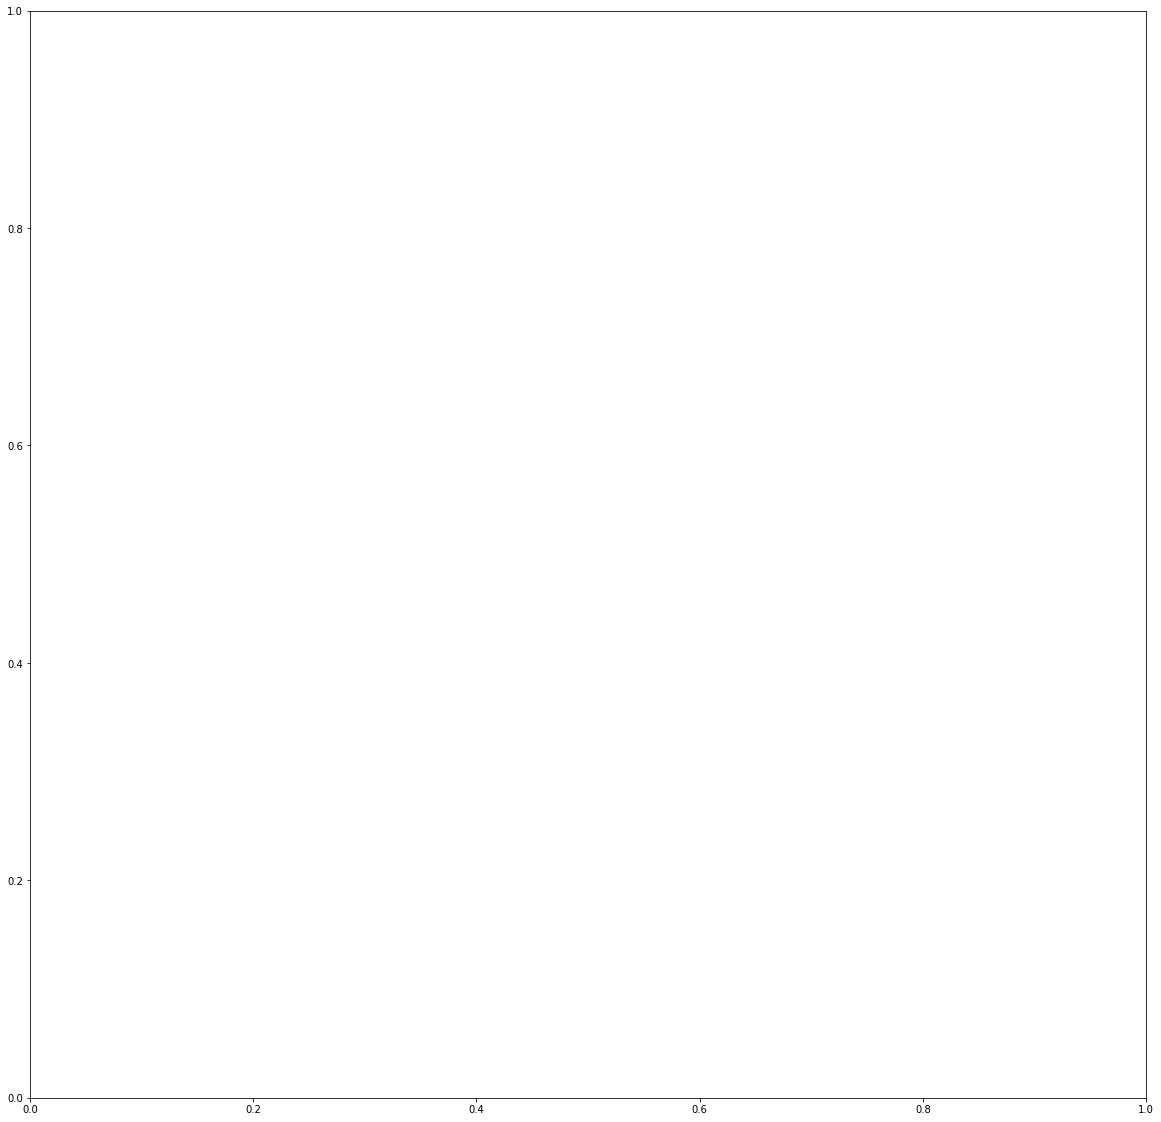

In [82]:
c=0
data_dic = {}
spikes = {}
for trial,bin in binned_dic.items():
    #print("trial:", trial)
    times,cells = [],[]
    for time,activities in bin.items():
        #print("time:", time)
        for cell,v in activities.items():
            if cell not in time_cells:  # to skip over behavior and metadata
                continue
            activity_sum = 0
            count = 0
            for x in v:
                activity_sum += x
                count += 1
            mean_activity = activity_sum / count
            #print("time:", time, "cell:", cell, "mean_act:", mean_activity)
            if c == 0:
                times.append(time)
                cells.append(cell-13)
            if (time,cell) not in spikes:
                spikes[(time,cell)] = []
                spikes[(time,cell)].append(mean_activity)
            else:
                spikes[(time,cell)].append(mean_activity)

data_dic["times"] = times
data_dic["cells"] = cells

spikes_list = []
for k,v in spikes.items():
    spikes_list.append(sum(v) / len(v))

data_dic["spikes"] = spikes_list


df = pd.DataFrame.from_dict(data_dic)
df = df.pivot(index='cells', columns='times', values='spikes')
fig, ax = plt.subplots(figsize=(20,20)) 
#sns.set(font_scale=1.4)
b = sns.heatmap(df, annot=False)
b.axes.set_title("Average time cell activity during reward",fontsize=30)
b.set_xlabel("Time (ms)",fontsize=28)
b.set_ylabel("Cell #",fontsize=28)
plt.savefig("plots/avrg_activity_reward_0.png")

# Make plots for number of time cells

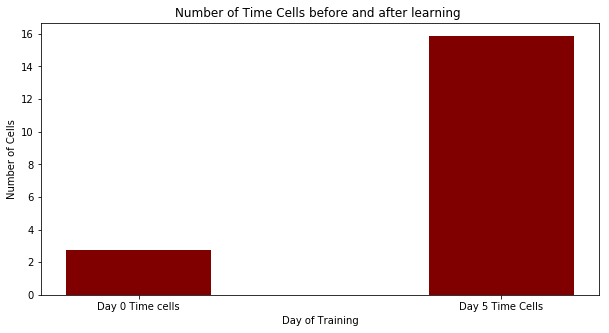

In [67]:
import numpy as np 
import matplotlib.pyplot as plt  
  
   
# creating the dataset 
data = {'Day 0 Time cells':2.74,  'Day 5 Time Cells':15.87} 
Day_of_Training = list(data.keys()) 
Percentage_of_Cells = list(data.values()) 
   
fig = plt.figure(figsize = (10, 5)) 
  #calculate %
# creating the bar plot 
plt.bar(Day_of_Training, Percentage_of_Cells, color ='maroon',  
        width = 0.4) 
  
plt.xlabel("Day of Training") 
plt.ylabel("Number of Cells") 
plt.title("Number of Time Cells before and after learning ") 
plt.show() 
